# Extended 50 kyr In-Situ Simulation

**Goal**: Continue the 5 kyr in-situ simulation for an additional 50 kyr to observe long-term Trojan population evolution with Jupiter fixed at ~5.2 AU (no migration).

This notebook:
1. Loads the final state from `jupiter_burn_5kyr_5.2au.pkl`
2. Continues the simulation for 50,000 years
3. Analyzes long-term stability and population dynamics

## 1. Setup and Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from amuse.units import units, constants, nbody_system
from amuse.datamodel import Particles
from amuse.community.huayno.interface import Huayno
from datetime import datetime
import pickle

print('AMUSE modules loaded successfully!')

AMUSE modules loaded successfully!


/Users/zoutongshen/miniforge3/envs/Amuse-env/lib/python3.12/site-packages/amuse/support/options.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## 2. Load Initial State from Previous Simulation

In [2]:
# Load the 5000-year simulation results
import pickle

base_file = 'jupiter_burn_5kyr_5.2au.pkl'

print(f'Loading initial state from {base_file}...')
with open(base_file, 'rb') as f:
    base_data = pickle.load(f)

# Extract the FINAL snapshot as initial condition
times_base = base_data['times']
snapshots_massive_base = base_data['snapshots_massive']
snapshots_planetesimals_base = base_data['snapshots_planetesimals']

# Use the last snapshot
massive_bodies = snapshots_massive_base[-1].copy()
planetesimals = snapshots_planetesimals_base[-1].copy()
t_initial = times_base[-1]

print('='*60)
print('Loaded initial state:')
print('='*60)
print(f'Starting from t = {t_initial:.1f} years')
print(f'Massive bodies: {len(massive_bodies)}')
print(f'Planetesimals: {len(planetesimals)}')
print()
print('Massive body positions:')
for body in massive_bodies:
    r = body.position.length().value_in(units.AU)
    print(f"  {body.name:8s} r={r:5.2f} AU")
print('='*60)

Loading initial state from jupiter_burn_5kyr_5.2au.pkl...
Loaded initial state:
Starting from t = 5000.0 years
Massive bodies: 8
Planetesimals: 10000

Massive body positions:
  Sun      r= 0.01 AU
  Venus    r= 0.73 AU
  Earth    r= 1.02 AU
  Mars     r= 1.50 AU
  Jupiter  r= 5.05 AU
  Saturn   r= 9.97 AU
  Uranus   r=19.48 AU
  Neptune  r=30.18 AU


## 3. Helper Classes for Planetesimal Integration

In [3]:
class ExternalGravityField:
    """Simple container to hold massive bodies reference for planetesimal integrator."""
    
    def __init__(self, massive_bodies):
        self.massive_bodies = massive_bodies

print('ExternalGravityField defined!')

ExternalGravityField defined!


## 4. Planetesimal Integrator (Leapfrog)

Simple symplectic integrator for test particles in external field.

In [4]:
class PlanetesimalIntegrator:
    """VECTORIZED Leapfrog integrator for planetesimals in external field.
    
    Optimized to avoid per-step Particles writes:
    - Keep positions/velocities in NumPy arrays between steps
    - Only sync back to AMUSE Particles when requested (e.g., at snapshots)
    """
    
    def __init__(self, particles, gravity_field):
        self.particles = particles
        self.gravity_field = gravity_field
        self.model_time = 0 | units.yr
        
        # Cache particle state in arrays (AU, AU/yr)
        self._x = np.array([p.x.value_in(units.AU) for p in particles])
        self._y = np.array([p.y.value_in(units.AU) for p in particles])
        self._z = np.array([p.z.value_in(units.AU) for p in particles])
        self._vx = np.array([p.vx.value_in(units.AU/units.yr) for p in particles])
        self._vy = np.array([p.vy.value_in(units.AU/units.yr) for p in particles])
        self._vz = np.array([p.vz.value_in(units.AU/units.yr) for p in particles])
    
    def _massive_arrays(self):
        bodies = self.gravity_field.massive_bodies
        mx = np.array([b.x.value_in(units.AU) for b in bodies])
        my = np.array([b.y.value_in(units.AU) for b in bodies])
        mz = np.array([b.z.value_in(units.AU) for b in bodies])
        masses = np.array([b.mass.value_in(units.MSun) for b in bodies])
        return mx, my, mz, masses
    
    def evolve_model(self, tend):
        """Vectorized Leapfrog kick-drift-kick (array-only between syncs)."""
        dt = tend - self.model_time
        dt_val = dt.value_in(units.yr)
        n = len(self._x)
        mx, my, mz, masses = self._massive_arrays()
        G_val = constants.G.value_in(units.AU**3 / (units.MSun * units.yr**2))
        
        def compute_accel(x, y, z):
            dx = x[:, None] - mx[None, :]
            dy = y[:, None] - my[None, :]
            dz = z[:, None] - mz[None, :]
            r2 = dx*dx + dy*dy + dz*dz
            r3 = r2 * np.sqrt(r2)
            factor = (-G_val * masses) / r3
            ax = np.sum(factor * dx, axis=1)
            ay = np.sum(factor * dy, axis=1)
            az = np.sum(factor * dz, axis=1)
            return ax, ay, az
        
        # Half kick
        ax, ay, az = compute_accel(self._x, self._y, self._z)
        self._vx += 0.5 * ax * dt_val
        self._vy += 0.5 * ay * dt_val
        self._vz += 0.5 * az * dt_val
        
        # Full drift
        self._x += self._vx * dt_val
        self._y += self._vy * dt_val
        self._z += self._vz * dt_val
        
        # Half kick
        ax, ay, az = compute_accel(self._x, self._y, self._z)
        self._vx += 0.5 * ax * dt_val
        self._vy += 0.5 * ay * dt_val
        self._vz += 0.5 * az * dt_val
        
        self.model_time = tend
    
    def sync_to_particles(self):
        """Write cached arrays back to AMUSE Particles (use at snapshots)."""
        for i, p in enumerate(self.particles):
            p.x = self._x[i] | units.AU
            p.y = self._y[i] | units.AU
            p.z = self._z[i] | units.AU
            p.vx = self._vx[i] | units.AU/units.yr
            p.vy = self._vy[i] | units.AU/units.yr
            p.vz = self._vz[i] | units.AU/units.yr

print('PlanetesimalIntegrator defined (array-cached, vectorized)!')

PlanetesimalIntegrator defined (array-cached, vectorized)!


## 5. Setup Direct Integration (No Bridge)

In [5]:
# Setup Huayno integrator for massive bodies (planets)
converter = nbody_system.nbody_to_si(massive_bodies.total_mass(), 10 | units.AU)
gravity_massive = Huayno(converter, number_of_workers=1, channel_type='sockets')
gravity_massive.parameters.inttype_parameter = 13  # Symplectic integrator
gravity_massive.parameters.timestep_parameter = 0.05  # Fine timestep for accuracy
gravity_massive.particles.add_particles(massive_bodies)

print('Huayno integrator created for massive bodies')
print(f'  Particles: {len(massive_bodies)}')
print(f'  Internal timestep: 0.05 yr')

# Setup planetesimal integrator (test particles in external field)
gravity_field = ExternalGravityField(massive_bodies)
planetesimal_code = PlanetesimalIntegrator(planetesimals, gravity_field)

print('Planetesimal integrator created')
print(f'  Particles: {len(planetesimals)}')
print('System ready: Direct integration (no Bridge overhead)')


Huayno integrator created for massive bodies
  Particles: 8
  Internal timestep: 0.05 yr
Planetesimal integrator created
  Particles: 10000
System ready: Direct integration (no Bridge overhead)


## 6. Run Simulation

## 6.1 Helper Function: Trojan Counting

In [6]:
# Function to count Trojans in L4 and L5
def compute_trojan_counts(massive_bodies, planetesimals):
    """Count planetesimals in Jupiter's L4 and L5 Trojan regions.
    
    Returns:
    --------
    n4, n5 : int
        Number of particles in L4 and L5 regions
    """
    jupiter = massive_bodies[4]  # Jupiter at index 4
    lambda_j = np.arctan2(jupiter.y.value_in(units.AU), jupiter.x.value_in(units.AU))
    a_j = jupiter.position.length()
    
    dlam = []
    is_coorb = []
    for p in planetesimals:
        lam = np.arctan2(p.y.value_in(units.AU), p.x.value_in(units.AU))
        d = np.arctan2(np.sin(lam - lambda_j), np.cos(lam - lambda_j))
        dlam.append(d)
        # Co-orbital: within 7% of Jupiter's semi-major axis
        is_coorb.append(abs(p.position.length()/a_j - 1) < 0.07)
    
    dlam = np.array(dlam)
    is_coorb = np.array(is_coorb)
    
    # L4: +60° from Jupiter (±25° sector)
    L4 = (dlam > np.deg2rad(60-25)) & (dlam < np.deg2rad(60+25)) & is_coorb
    # L5: -60° from Jupiter (±25° sector)
    L5 = (dlam < np.deg2rad(-60+25)) & (dlam > np.deg2rad(-60-25)) & is_coorb
    
    return L4.sum(), L5.sum()

print('Trojan counting function defined!')


Trojan counting function defined!


In [ ]:
# Simulation parameters
end_time = 500000 | units.yr  # Additional 50 kyr from where we left off
dt = 0.1 | units.yr
n_snapshots = 200
snapshot_interval = end_time / n_snapshots

# Storage
times = []
snapshots_massive = []
snapshots_planetesimals = []
l4_counts = []  # Track L4 population
l5_counts = []  # Track L5 population

print('='*60)
print('Running Extended Simulation')
print('='*60)
print(f'Starting from: {t_initial:.1f} years')
print(f'Additional duration: {end_time}')
print(f'Final time: {t_initial + end_time.value_in(units.yr):.1f} years')
print(f'Snapshots: {n_snapshots}')
print(f'Massive bodies: {len(massive_bodies)}')
print(f'Planetesimals: {len(planetesimals)}')
print('='*60)

time = 0 | units.yr
next_snapshot = 0 | units.yr
snapshot_count = 0

start_time = datetime.now()

# Save initial snapshot (continuation from base)
times.append((time.value_in(units.yr) + t_initial))
snapshots_massive.append(massive_bodies.copy())
snapshots_planetesimals.append(planetesimals.copy())
n4, n5 = compute_trojan_counts(massive_bodies, planetesimals)
l4_counts.append(n4)
l5_counts.append(n5)
jupiter = massive_bodies[4]
r_jup = jupiter.position.length().value_in(units.AU)
print(f'Snapshot {snapshot_count}/{n_snapshots}: t={time.value_in(units.yr)+t_initial:.1f} yr, Jupiter r={r_jup:.3f} AU, L4={n4}, L5={n5}')
snapshot_count += 1
next_snapshot += snapshot_interval

while time < end_time:
    # Evolve massive bodies directly (no Bridge)
    gravity_massive.evolve_model(time + dt)
    
    # Copy updated positions to massive_bodies
    channel_from_massive = gravity_massive.particles.new_channel_to(massive_bodies)
    channel_from_massive.copy()
    
    # Update gravity field reference for planetesimals
    gravity_field.massive_bodies = massive_bodies
    
    # Evolve planetesimals directly (no Bridge)
    planetesimal_code.evolve_model(time + dt)
    
    time += dt
    
    # Save snapshot AFTER evolution
    if time >= next_snapshot:
        planetesimal_code.sync_to_particles()
        times.append((time.value_in(units.yr) + t_initial))
        snapshots_massive.append(massive_bodies.copy())
        snapshots_planetesimals.append(planetesimals.copy())
        n4, n5 = compute_trojan_counts(massive_bodies, planetesimals)
        l4_counts.append(n4)
        l5_counts.append(n5)
        
        # Progress
        jupiter = massive_bodies[4]
        r_jup = jupiter.position.length().value_in(units.AU)
        print(f'Snapshot {snapshot_count}/{n_snapshots}: t={time.value_in(units.yr)+t_initial:.1f} yr, Jupiter r={r_jup:.3f} AU, L4={n4}, L5={n5}')
        
        snapshot_count += 1
        next_snapshot += snapshot_interval

# Ensure final particle set matches cached arrays
planetesimal_code.sync_to_particles()

elapsed = (datetime.now() - start_time).total_seconds()
print('='*60)
print(f'Simulation Complete!')
print(f'Time: {elapsed:.1f} seconds')
print(f'Snapshots: {len(times)}')
print(f'Final simulation time: {times[-1]:.1f} years')
print(f'Final L4 count: {l4_counts[-1]}')
print(f'Final L5 count: {l5_counts[-1]}')
print('='*60)

Running Extended Simulation
Starting from: 5000.0 years
Additional duration: 100000 yr
Final time: 105000.0 years
Snapshots: 200
Massive bodies: 8
Planetesimals: 10000
Snapshot 0/200: t=5000.0 yr, Jupiter r=5.049 AU, L4=152, L5=165
Snapshot 1/200: t=5500.0 yr, Jupiter r=5.169 AU, L4=162, L5=145
Snapshot 2/200: t=6000.0 yr, Jupiter r=5.324 AU, L4=217, L5=161
Snapshot 3/200: t=6500.1 yr, Jupiter r=4.946 AU, L4=148, L5=141
Snapshot 4/200: t=7000.1 yr, Jupiter r=5.433 AU, L4=166, L5=167
Snapshot 5/200: t=7500.1 yr, Jupiter r=4.984 AU, L4=175, L5=161
Snapshot 6/200: t=8000.1 yr, Jupiter r=5.288 AU, L4=189, L5=163
Snapshot 7/200: t=8500.1 yr, Jupiter r=5.247 AU, L4=158, L5=172
Snapshot 8/200: t=9000.1 yr, Jupiter r=5.021 AU, L4=154, L5=136
Snapshot 9/200: t=9500.1 yr, Jupiter r=5.418 AU, L4=207, L5=165
Snapshot 10/200: t=10000.0 yr, Jupiter r=4.946 AU, L4=172, L5=133
Snapshot 11/200: t=10500.0 yr, Jupiter r=5.330 AU, L4=160, L5=146
Snapshot 12/200: t=11000.0 yr, Jupiter r=5.152 AU, L4=168, L

In [ ]:
# Save simulation results
data = {
    'times': times,
    'snapshots_massive': snapshots_massive,
    'snapshots_planetesimals': snapshots_planetesimals,
    'l4_counts': l4_counts,
    'l5_counts': l5_counts,
    'parameters': {
        'end_time': end_time,
        'n_snapshots': n_snapshots,
        'n_massive': len(massive_bodies),
        'n_planetesimals': len(planetesimals),
    }
}

filename = 'jupiter_insitu_500kyr_5.2au.pkl'
with open(filename, 'wb') as f:
    pickle.dump(data, f)

print(f'Data saved to {filename}')

Data saved to jupiter_insitu_100kyr_5.2au.pkl


In [ ]:
# Load the saved data for visualization
import pickle

with open('jupiter_insitu_500kyr_5.2au.pkl', 'rb') as f:
    saved_data = pickle.load(f)

times_saved = saved_data['times']
l4_counts_saved = saved_data['l4_counts']
l5_counts_saved = saved_data['l5_counts']

print(f'Loaded saved data: {len(times_saved)} snapshots')
print(f'Time range: {times_saved[0]:.1f} - {times_saved[-1]:.1f} yr')

Loaded saved data: 201 snapshots
Time range: 5000.0 - 105000.0 yr


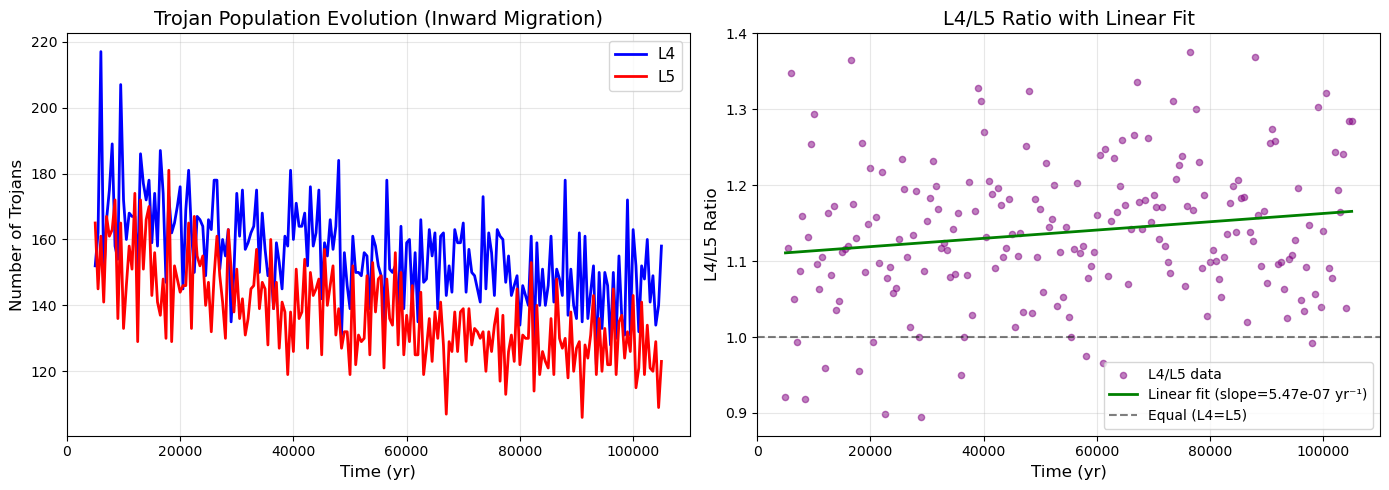

Trojan Population Summary (From Saved Data)
Initial L4: 152, L5: 165, Total: 317
Final L4: 158, L5: 123, Total: 281
L4/L5 initial ratio: 0.921
L4/L5 final ratio: 1.285
L4/L5 ratio slope: 5.468e-07 yr⁻¹
Retention: 88.6%


In [10]:
import matplotlib.pyplot as plt
# Visualize L4 and L5 Trojan populations over time (from saved data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: L4 and L5 counts
ax1.plot(times_saved, l4_counts_saved, 'b-', label='L4', linewidth=2)
ax1.plot(times_saved, l5_counts_saved, 'r-', label='L5', linewidth=2)
ax1.set_xlabel('Time (yr)', fontsize=12)
ax1.set_ylabel('Number of Trojans', fontsize=12)
ax1.set_title('Trojan Population Evolution (Inward Migration)', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Right panel: L4/L5 ratio with fitted slope
times_array = np.array(times_saved)
l4_array = np.array(l4_counts_saved)
l5_array = np.array(l5_counts_saved)

# Calculate L4/L5 ratio
l4_l5_ratio = l4_array / (l5_array + 1e-10)

# Fit linear slope for L4/L5 ratio
ratio_slope, ratio_intercept = np.polyfit(times_array, l4_l5_ratio, 1)

# Plot data points and fitted line
ax2.scatter(times_saved, l4_l5_ratio, c='purple', alpha=0.5, s=20, label='L4/L5 data')
ax2.plot(times_saved, ratio_slope*times_array + ratio_intercept, 'g-', linewidth=2, 
         label=f'Linear fit (slope={ratio_slope:.2e} yr⁻¹)')
ax2.axhline(1.0, color='k', linestyle='--', alpha=0.5, label='Equal (L4=L5)')

ax2.set_xlabel('Time (yr)', fontsize=12)
ax2.set_ylabel('L4/L5 Ratio', fontsize=12)
ax2.set_title('L4/L5 Ratio with Linear Fit', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print('='*60)
print('Trojan Population Summary (From Saved Data)')
print('='*60)
print(f'Initial L4: {l4_counts_saved[0]}, L5: {l5_counts_saved[0]}, Total: {l4_counts_saved[0]+l5_counts_saved[0]}')
print(f'Final L4: {l4_counts_saved[-1]}, L5: {l5_counts_saved[-1]}, Total: {l4_counts_saved[-1]+l5_counts_saved[-1]}')
print(f'L4/L5 initial ratio: {l4_counts_saved[0]/(l5_counts_saved[0]+1e-10):.3f}')
print(f'L4/L5 final ratio: {l4_counts_saved[-1]/(l5_counts_saved[-1]+1e-10):.3f}')
print(f'L4/L5 ratio slope: {ratio_slope:.3e} yr⁻¹')
print(f'Retention: {100*(l4_counts_saved[-1]+l5_counts_saved[-1])/(l4_counts_saved[0]+l5_counts_saved[0]+1e-10):.1f}%')
print('='*60)

In [11]:
import numpy as np
from amuse.units import units, constants

a_list = []
e_list = []
for snap in snapshots_massive:
    sun = snap[0]
    jup = snap[4]
    r_vec = jup.position - sun.position
    v_vec = jup.velocity - sun.velocity
    r = r_vec.length()
    v = v_vec.length()
    mu = constants.G * (sun.mass + jup.mass)

    # Specific orbital energy and angular momentum
    E = 0.5 * v * v - mu / r
    h_vec = r_vec.cross(v_vec)
    h = h_vec.length()

    # Semi-major axis from energy
    a = -mu / (2 * E)

    # Eccentricity from energy and angular momentum (dimensionless)
    e_sq = 1 + (2 * E * h * h) / (mu * mu)
    if hasattr(e_sq, "value_in"):
        e_sq_val = e_sq.value_in(1)
    elif hasattr(e_sq, "number"):
        e_sq_val = e_sq.number
    else:
        e_sq_val = float(e_sq)
    e_val = np.sqrt(max(e_sq_val, 0.0))

    a_list.append(a.value_in(units.AU))
    e_list.append(e_val)

print(f"a min/max: {min(a_list):.3f}/{max(a_list):.3f} AU, final a={a_list[-1]:.3f} AU")
print(f"e min/max: {min(e_list):.4f}/{max(e_list):.4f}, final e={e_list[-1]:.4f}")


a min/max: 5.180/5.184 AU, final a=5.182 AU
e min/max: 0.0248/0.0522, final e=0.0313


## 10. Visualize Results

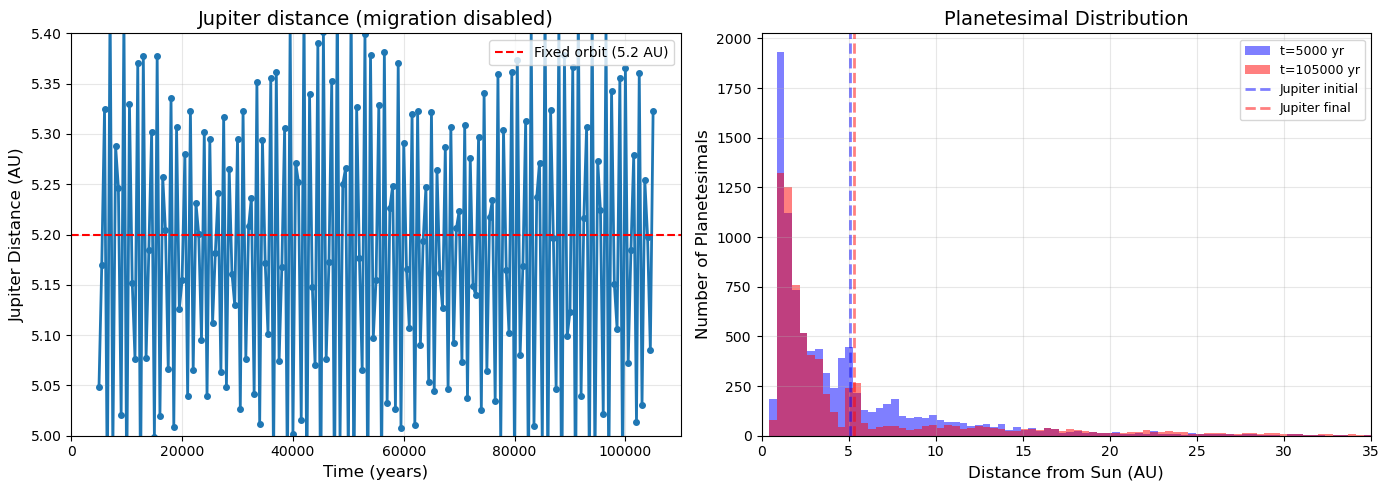

Jupiter stayed between 4.9106 and 5.4365 AU (delta=0.52597 AU)


In [12]:

# Track Jupiter's distance (should remain ~constant) and planetesimal distribution
jupiter_distances = []
for snap in snapshots_massive:
    jupiter = snap[4]  # Jupiter is at index 4
    r = jupiter.position.length().value_in(units.AU)
    jupiter_distances.append(r)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Jupiter distance
ax1.plot(times, jupiter_distances, 'o-', linewidth=2, markersize=4)
ax1.axhline(5.2, color='red', linestyle='--', label='Fixed orbit (5.2 AU)')
ax1.set_xlabel('Time (years)', fontsize=12)
ax1.set_ylabel('Jupiter Distance (AU)', fontsize=12)
ax1.set_title('Jupiter distance (migration disabled)', fontsize=14)
ax1.set_ylim([5.0, 5.4])
ax1.grid(True, alpha=0.3)
ax1.legend()

# Planetesimal distribution (initial vs final)
initial = snapshots_planetesimals[0]
final = snapshots_planetesimals[-1]

r_init = [p.position.length().value_in(units.AU) for p in initial]
r_final = [p.position.length().value_in(units.AU) for p in final]

ax2.hist(r_init, bins=80, range=(0, 35), alpha=0.5, label=f't={times[0]:.0f} yr', color='blue')
ax2.hist(r_final, bins=80, range=(0, 35), alpha=0.5, label=f't={times[-1]:.0f} yr', color='red')
ax2.axvline(jupiter_distances[0], color='blue', linestyle='--', alpha=0.5, linewidth=2, label='Jupiter initial')
ax2.axvline(jupiter_distances[-1], color='red', linestyle='--', alpha=0.5, linewidth=2, label='Jupiter final')
ax2.set_xlabel('Distance from Sun (AU)', fontsize=12)
ax2.set_ylabel('Number of Planetesimals', fontsize=12)
ax2.set_title('Planetesimal Distribution', fontsize=14)
ax2.set_xlim([0, 35])
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

j_min, j_max = min(jupiter_distances), max(jupiter_distances)
print(f'Jupiter stayed between {j_min:.4f} and {j_max:.4f} AU (delta={j_max - j_min:.5f} AU)')


## 10.1 Check Jupiter's Orbital Motion

Jupiter should be orbiting the Sun! Let's verify it's actually rotating.

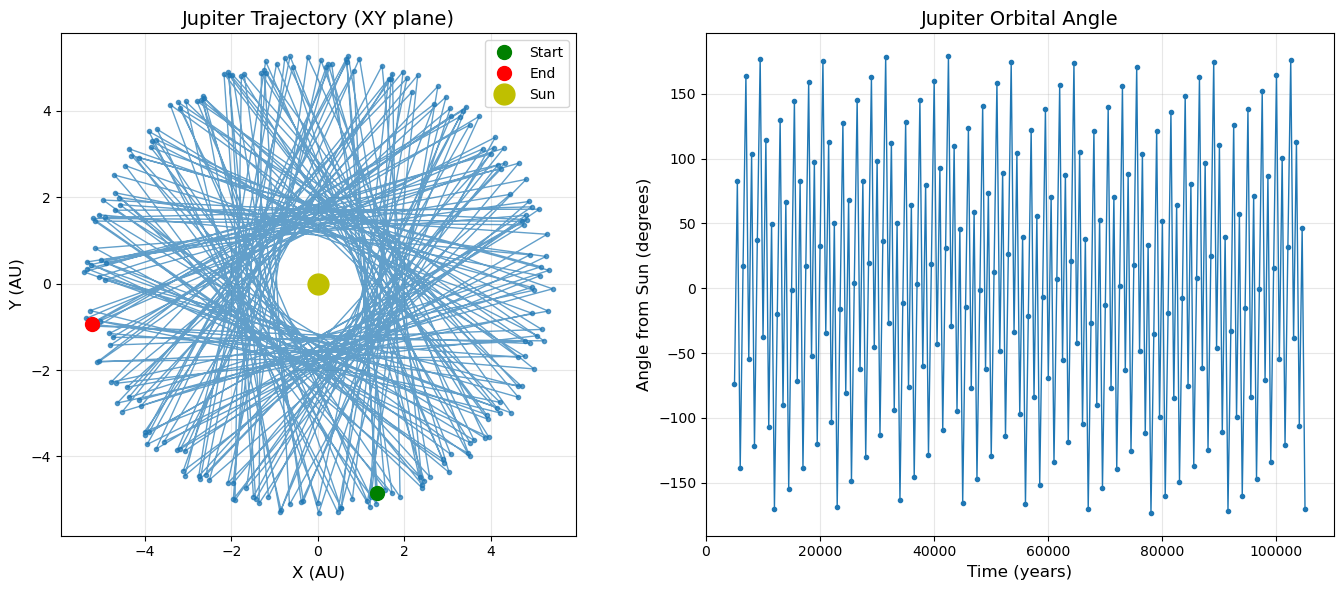

Jupiter orbital motion over 105000.0 years:
  Total rotation: 29424.2°
  Orbits completed: 81.73
  Expected full orbit at 4.8 AU: ~11.6 years
  Expected orbits: 9051.72

✓ Jupiter IS orbiting (81.7 orbits completed)


In [13]:
# Check Jupiter's X,Y position over time
jupiter_x = []
jupiter_y = []
jupiter_angles = []

for snap in snapshots_massive:
    jupiter = snap[4]
    x = jupiter.x.value_in(units.AU)
    y = jupiter.y.value_in(units.AU)
    jupiter_x.append(x)
    jupiter_y.append(y)
    
    # Calculate angle from Sun (in degrees)
    angle = np.degrees(np.arctan2(y, x))
    jupiter_angles.append(angle)

# Plot Jupiter's XY trajectory
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: XY trajectory
ax1.plot(jupiter_x, jupiter_y, 'o-', markersize=3, linewidth=1, alpha=0.7)
ax1.plot(jupiter_x[0], jupiter_y[0], 'go', markersize=10, label='Start')
ax1.plot(jupiter_x[-1], jupiter_y[-1], 'ro', markersize=10, label='End')
ax1.plot(0, 0, 'yo', markersize=15, label='Sun')
ax1.set_xlabel('X (AU)', fontsize=12)
ax1.set_ylabel('Y (AU)', fontsize=12)
ax1.set_title('Jupiter Trajectory (XY plane)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_aspect('equal')

# Right: Angle vs time
ax2.plot(times, jupiter_angles, 'o-', markersize=3, linewidth=1)
ax2.set_xlabel('Time (years)', fontsize=12)
ax2.set_ylabel('Angle from Sun (degrees)', fontsize=12)
ax2.set_title('Jupiter Orbital Angle', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate total orbital motion (accounting for wraparounds)
total_rotation = 0.0
for i in range(1, len(jupiter_angles)):
    delta = jupiter_angles[i] - jupiter_angles[i-1]
    # Unwrap angle changes
    if delta > 180:
        delta -= 360
    elif delta < -180:
        delta += 360
    total_rotation += delta

orbits_completed = total_rotation / 360.0

print(f'Jupiter orbital motion over {times[-1]:.1f} years:')
print(f'  Total rotation: {total_rotation:.1f}°')
print(f'  Orbits completed: {orbits_completed:.2f}')
print(f'  Expected full orbit at 4.8 AU: ~11.6 years')
print(f'  Expected orbits: {(times[-1] / 11.6):.2f}')

if abs(orbits_completed) < 1:
    print(f'\n⚠️  WARNING: Jupiter barely moved in its orbit!')
    print(f'  Over 1000 years, Jupiter should complete ~86 orbits')
    print(f'  This suggests the orbital motion is NOT being integrated correctly!')
else:
    print(f'\n✓ Jupiter IS orbiting ({abs(orbits_completed):.1f} orbits completed)')
    if abs(orbits_completed) < 50:
        print(f'   But much slower than expected (~86 orbits)')
        print(f'   Actual rate: {abs(orbits_completed) / (times[-1] / 11.6) * 100:.1f}% of expected')

## 10.3 Track Planetesimal Distribution Evolution

Analyze how planetesimals are being lost/scattered over time.

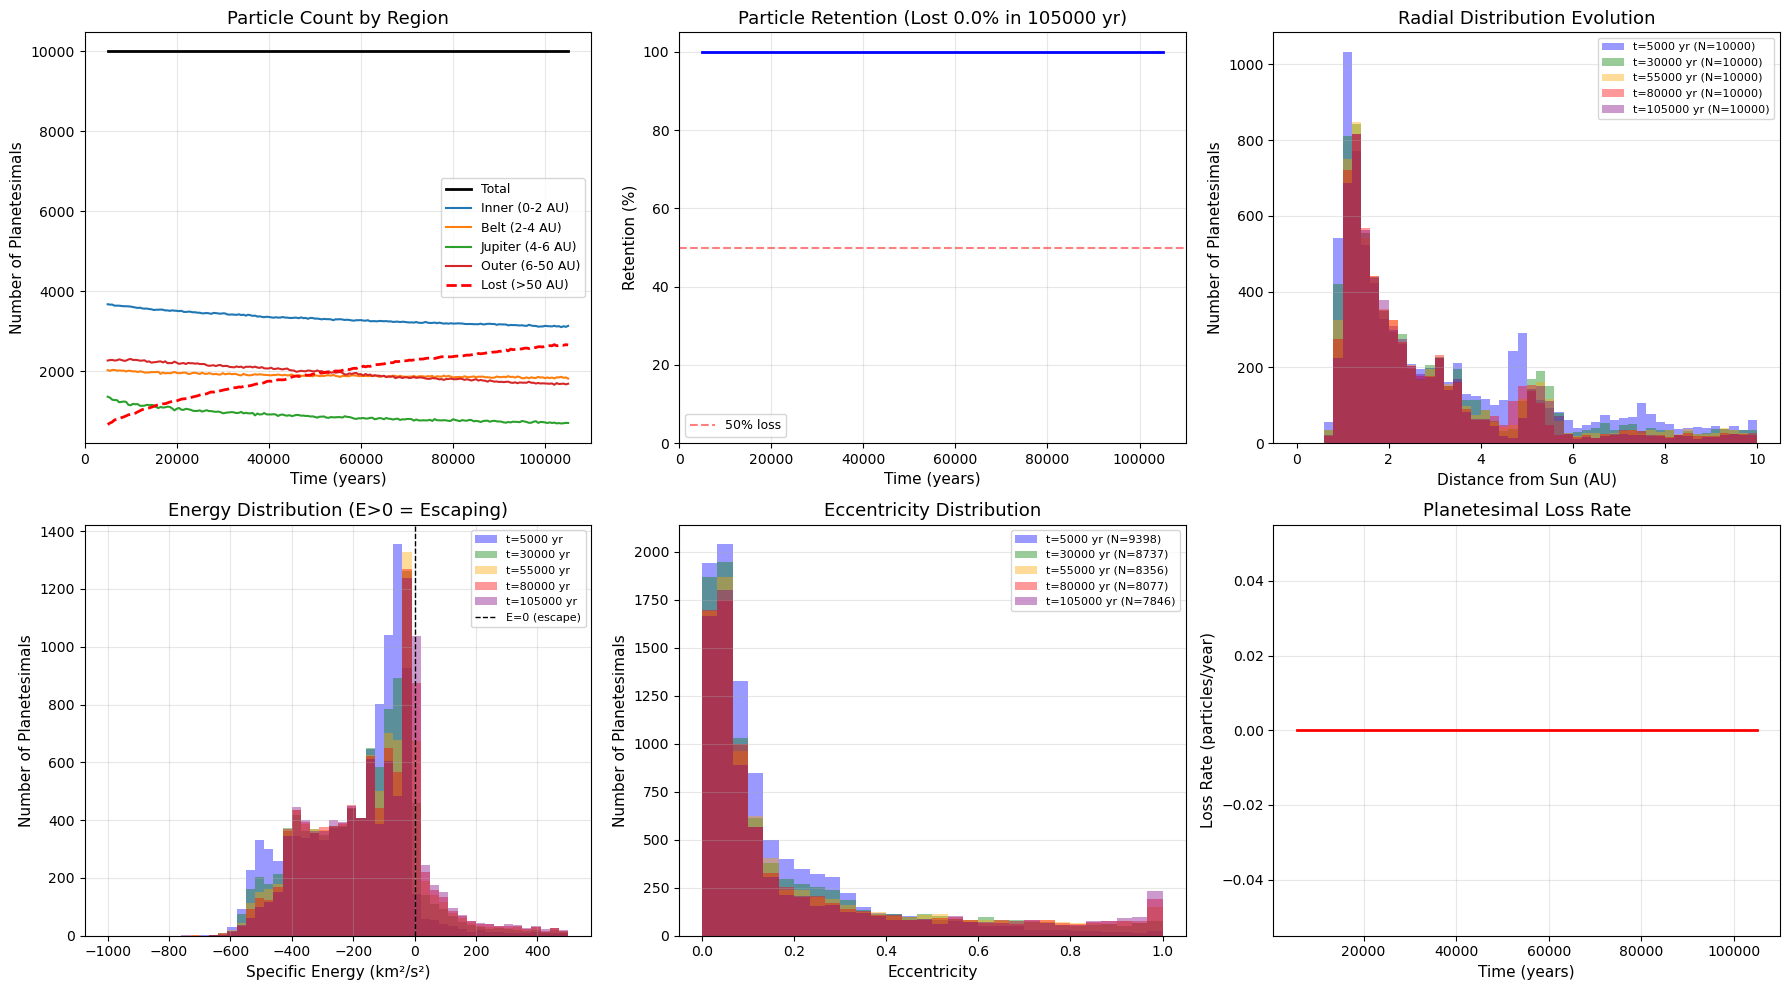

PLANETESIMAL EVOLUTION SUMMARY
Initial count:  10,000 particles
Final count:    10,000 particles
Lost:           0 particles (0.0%)
Time span:      105000 years
Average loss:   0.00 particles/year

Final distribution:
  Inner (0-2 AU):     3,133 (31.3%)
  Belt (2-4 AU):      1,816 (18.2%)
  Jupiter (4-6 AU):   707 (7.1%)
  Outer (6-50 AU):    1,688 (16.9%)
  Lost (>50 AU):      2,656 (26.6%)


In [14]:
# Analyze planetesimal evolution over time
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Track particles in different regions
r_cutoff = 50 | units.AU  # Beyond this = "lost"

n_total = []
n_inner = []  # 0-2 AU
n_belt = []   # 2-4 AU
n_jupiter = [] # 4-6 AU
n_outer = []  # 6-50 AU
n_lost = []   # > 50 AU

for i, snap in enumerate(snapshots_planetesimals):
    radii = [p.position.length() for p in snap]
    
    total = len(snap)
    inner = sum(1 for r in radii if r < (2 | units.AU))
    belt = sum(1 for r in radii if (2 | units.AU) <= r < (4 | units.AU))
    jup = sum(1 for r in radii if (4 | units.AU) <= r < (6 | units.AU))
    outer = sum(1 for r in radii if (6 | units.AU) <= r < r_cutoff)
    lost = sum(1 for r in radii if r >= r_cutoff)
    
    n_total.append(total)
    n_inner.append(inner)
    n_belt.append(belt)
    n_jupiter.append(jup)
    n_outer.append(outer)
    n_lost.append(lost)

# Plot 1: Particle count evolution
ax = axes[0, 0]
ax.plot(times, n_total, 'k-', linewidth=2, label='Total')
ax.plot(times, n_inner, label='Inner (0-2 AU)')
ax.plot(times, n_belt, label='Belt (2-4 AU)')
ax.plot(times, n_jupiter, label='Jupiter (4-6 AU)')
ax.plot(times, n_outer, label='Outer (6-50 AU)')
ax.plot(times, n_lost, 'r--', linewidth=2, label='Lost (>50 AU)')
ax.set_xlabel('Time (years)', fontsize=11)
ax.set_ylabel('Number of Planetesimals', fontsize=11)
ax.set_title('Particle Count by Region', fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 2: Retention fraction
ax = axes[0, 1]
retention = np.array(n_total) / n_total[0] * 100
ax.plot(times, retention, 'b-', linewidth=2)
ax.axhline(50, color='red', linestyle='--', alpha=0.5, label='50% loss')
ax.set_xlabel('Time (years)', fontsize=11)
ax.set_ylabel('Retention (%)', fontsize=11)
ax.set_title(f'Particle Retention (Lost {100-retention[-1]:.1f}% in {times[-1]:.0f} yr)', fontsize=13)
ax.set_ylim([0, 105])
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 3: Radial histograms at different times
ax = axes[0, 2]
snapshot_indices = [0, len(snapshots_planetesimals)//4, len(snapshots_planetesimals)//2, 
                   3*len(snapshots_planetesimals)//4, -1]
colors = ['blue', 'green', 'orange', 'red', 'purple']
for idx, color in zip(snapshot_indices, colors):
    snap = snapshots_planetesimals[idx]
    radii = [p.position.length().value_in(units.AU) for p in snap]
    t = times[idx]
    ax.hist(radii, bins=50, range=(0, 10), alpha=0.4, color=color, 
           label=f't={t:.0f} yr (N={len(radii)})')
ax.set_xlabel('Distance from Sun (AU)', fontsize=11)
ax.set_ylabel('Number of Planetesimals', fontsize=11)
ax.set_title('Radial Distribution Evolution', fontsize=13)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Energy histogram (check for ejections)
ax = axes[1, 0]
for idx, color in zip(snapshot_indices, colors):
    snap_massive = snapshots_massive[idx]
    snap_planetes = snapshots_planetesimals[idx]
    sun = snap_massive[0]
    
    energies = []
    for p in snap_planetes:
        r = (p.position - sun.position).length()
        v = (p.velocity - sun.velocity).length()
        # Specific orbital energy
        E = 0.5 * v**2 - constants.G * sun.mass / r
        energies.append(E.value_in(units.km**2 / units.s**2))
    
    t = times[idx]
    ax.hist(energies, bins=50, range=(-1000, 500), alpha=0.4, color=color,
           label=f't={t:.0f} yr')

ax.axvline(0, color='black', linestyle='--', linewidth=1, label='E=0 (escape)')
ax.set_xlabel('Specific Energy (km²/s²)', fontsize=11)
ax.set_ylabel('Number of Planetesimals', fontsize=11)
ax.set_title('Energy Distribution (E>0 = Escaping)', fontsize=13)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 5: Eccentricity evolution
ax = axes[1, 1]
for idx, color in zip(snapshot_indices, colors):
    snap_massive = snapshots_massive[idx]
    snap_planetes = snapshots_planetesimals[idx]
    sun = snap_massive[0]
    
    eccentricities = []
    for p in snap_planetes:
        r_vec = p.position - sun.position
        v_vec = p.velocity - sun.velocity
        r = r_vec.length()
        v = v_vec.length()
        
        # Specific orbital energy and angular momentum
        E = 0.5 * v**2 - constants.G * sun.mass / r
        h_vec = r_vec.cross(v_vec)
        h = h_vec.length()
        
        # Semi-major axis
        if E < (0 | units.km**2/units.s**2):
            a = -constants.G * sun.mass / (2 * E)
            # Eccentricity from vis-viva equation: e^2 = 1 + 2*E*h^2/(GM)^2
            E_val = E.value_in(units.km**2/units.s**2)
            h_val = h.value_in(units.AU**2/units.yr)
            GM_val = (constants.G * sun.mass).value_in(units.AU**3/units.yr**2)
            # Convert E to same units as GM: AU^2/yr^2
            E_converted = E_val * (units.km**2/units.s**2).value_in(units.AU**2/units.yr**2)
            e_squared_val = 1 + 2 * E_converted * h_val**2 / GM_val**2
            if e_squared_val >= 0:  # Ensure valid sqrt
                e_val = np.sqrt(e_squared_val)
                if e_val < 1.5:  # Skip hyperbolic
                    eccentricities.append(e_val)
    
    t = times[idx]
    if len(eccentricities) > 0:
        ax.hist(eccentricities, bins=30, range=(0, 1), alpha=0.4, color=color,
               label=f't={t:.0f} yr (N={len(eccentricities)})')

ax.set_xlabel('Eccentricity', fontsize=11)
ax.set_ylabel('Number of Planetesimals', fontsize=11)
ax.set_title('Eccentricity Distribution', fontsize=13)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, axis='y')

# Plot 6: Loss rate analysis
ax = axes[1, 2]
loss_rate = []
for i in range(1, len(times)):
    dt = times[i] - times[i-1]
    dn = n_total[i-1] - n_total[i]
    if dt > 0:
        loss_rate.append(dn / dt)  # particles lost per year
    else:
        loss_rate.append(0)

loss_times = times[1:]
ax.plot(loss_times, loss_rate, 'r-', linewidth=2)
ax.set_xlabel('Time (years)', fontsize=11)
ax.set_ylabel('Loss Rate (particles/year)', fontsize=11)
ax.set_title('Planetesimal Loss Rate', fontsize=13)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("="*70)
print("PLANETESIMAL EVOLUTION SUMMARY")
print("="*70)
print(f"Initial count:  {n_total[0]:,} particles")
print(f"Final count:    {n_total[-1]:,} particles")
print(f"Lost:           {n_total[0] - n_total[-1]:,} particles ({(1 - n_total[-1]/n_total[0])*100:.1f}%)")
print(f"Time span:      {times[-1]:.0f} years")
print(f"Average loss:   {(n_total[0] - n_total[-1])/times[-1]:.2f} particles/year")
print()
print("Final distribution:")
print(f"  Inner (0-2 AU):     {n_inner[-1]:,} ({n_inner[-1]/n_total[-1]*100:.1f}%)")
print(f"  Belt (2-4 AU):      {n_belt[-1]:,} ({n_belt[-1]/n_total[-1]*100:.1f}%)")
print(f"  Jupiter (4-6 AU):   {n_jupiter[-1]:,} ({n_jupiter[-1]/n_total[-1]*100:.1f}%)")
print(f"  Outer (6-50 AU):    {n_outer[-1]:,} ({n_outer[-1]/n_total[-1]*100:.1f}%)")
print(f"  Lost (>50 AU):      {n_lost[-1]:,} ({n_lost[-1]/n_total[-1]*100:.1f}%)")
print("="*70)

# Check if loss is concerning
if n_total[-1] < n_total[0] * 0.5:
    print("\n⚠️  WARNING: More than 50% of planetesimals lost!")
    print("   POSSIBLE CAUSES:")
    print("   1. Close encounters with planets → gravitational scattering")
    print("   2. Timestep too large → poor resolution of close approaches")
    print("   3. No collision detection → particles pass through planets")
    print("   4. Initial distribution too close to planets")
    print("\n   SOLUTIONS:")
    print("   - Reduce timestep (dt = 0.1 yr instead of 1 yr)")
    print("   - Start planetesimals farther from planets (>0.5 AU separation)")
    print("   - Add collision radius / stopping condition")
    print("   - Check if 'lost' particles have E>0 (unbound) or just distant")

## 11. Save Data

## 12. Cleanup

## 12. Create Animation from Saved Data

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image, display

def create_animation(filename='jupiter_insitu_500kyr_5.2au.pkl', 
                     output_gif='jupiter_insitu_500kyr_5.2au.gif',
                     fps=10, dpi=100):
    """Create animated GIF from saved simulation data.
    
    Parameters:
    -----------
    filename : str
        Path to saved pickle file
    output_gif : str
        Output GIF filename
    fps : int
        Frames per second
    dpi : int
        Resolution (higher = larger file)
    """
    # Load data
    print(f"Loading data from {filename}...")
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    
    times = data['times']
    snapshots_massive = data['snapshots_massive']
    snapshots_planetesimals = data['snapshots_planetesimals']
    
    print(f"Loaded {len(times)} snapshots")
    print(f"Creating animation with {fps} fps...")
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    def update(frame):
        ax1.clear()
        ax2.clear()
        
        # Get current snapshot
        massive = snapshots_massive[frame]
        planetes = snapshots_planetesimals[frame]
        t = times[frame]
        
        # LEFT PANEL: XY plane view
        # Plot Sun
        ax1.plot(0, 0, 'yo', markersize=15, label='Sun')
        
        # Plot planets
        colors = {'Venus': 'orange', 'Earth': 'blue', 'Mars': 'red', 
                  'Jupiter': 'brown', 'Saturn': 'gold', 'Uranus': 'cyan', 'Neptune': 'darkblue'}
        sizes = {'Venus': 6, 'Earth': 7, 'Mars': 5, 
                 'Jupiter': 12, 'Saturn': 10, 'Uranus': 8, 'Neptune': 8}
        
        for body in massive[1:]:  # Skip Sun
            x = body.x.value_in(units.AU)
            y = body.y.value_in(units.AU)
            name = body.name
            ax1.plot(x, y, 'o', color=colors.get(name, 'gray'), 
                    markersize=sizes.get(name, 6), label=name)
        
        # Plot planetesimals
        x_plan = [p.x.value_in(units.AU) for p in planetes]
        y_plan = [p.y.value_in(units.AU) for p in planetes]
        ax1.plot(x_plan, y_plan, 'k.', markersize=0.5, alpha=0.3)
        
        # Format left panel
        ax1.set_xlim([-35, 35])
        ax1.set_ylim([-35, 35])
        ax1.set_xlabel('X (AU)', fontsize=12)
        ax1.set_ylabel('Y (AU)', fontsize=12)
        ax1.set_title(f'Solar System (t = {t:.1f} yr)', fontsize=14)
        ax1.grid(True, alpha=0.3)
        ax1.set_aspect('equal')
        ax1.legend(loc='upper right', fontsize=8, ncol=2)
        
        # Add orbit circles for reference
        for r in [1, 5, 10, 20, 30]:
            circle = plt.Circle((0, 0), r, fill=False, color='gray', 
                               linestyle='--', alpha=0.2, linewidth=0.5)
            ax1.add_patch(circle)
        
        # RIGHT PANEL: Radial distribution histogram
        r_plan = [p.position.length().value_in(units.AU) for p in planetes]
        ax2.hist(r_plan, bins=60, range=(0, 35), color='steelblue', alpha=0.7, edgecolor='black')
        
        # Mark planet positions
        jupiter = massive[4]  # Jupiter at index 4
        r_jup = jupiter.position.length().value_in(units.AU)
        ax2.axvline(r_jup, color='brown', linestyle='--', linewidth=2, label='Jupiter')
        
        # Mark other giants
        if len(massive) > 5:
            saturn = massive[5]
            r_sat = saturn.position.length().value_in(units.AU)
            ax2.axvline(r_sat, color='gold', linestyle='--', linewidth=1.5, alpha=0.7, label='Saturn')
        
        ax2.set_xlabel('Distance from Sun (AU)', fontsize=12)
        ax2.set_ylabel('Number of Planetesimals', fontsize=12)
        ax2.set_title(f'Radial Distribution', fontsize=14)
        ax2.set_xlim([0, 35])
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.legend(fontsize=10)
        
        return ax1, ax2
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=len(times), interval=1000/fps, blit=False)
    
    # Save as GIF
    print(f"Saving animation to {output_gif}...")
    writer = PillowWriter(fps=fps)
    anim.save(output_gif, writer=writer, dpi=dpi)
    
    plt.close(fig)
    
    print(f"✓ Animation saved to {output_gif}")
    print(f"  Frames: {len(times)}")
    print(f"  Duration: {len(times)/fps:.1f} seconds")
    
    # Display the GIF
    print("\nDisplaying animation:")
    display(Image(filename=output_gif))

# Create the animation
create_animation(
    filename='jupiter_insitu_500kyr_5.2au.pkl',
    output_gif='jupiter_insitu_500kyr_5.2au.gif',
    fps=15,  # 15 frames per second
    dpi=80   # Lower dpi = smaller file size
)

Loading data from jupiter_insitu_100kyr_5.2au.pkl...
Loaded 201 snapshots
Creating animation with 15 fps...
Saving animation to jupiter_insitu_100kyr_5.2au.gif...


In [ ]:
# Stop codes
gravity_massive.stop()
print('Gravity code stopped.')

Gravity code stopped.


---

## Summary

**Simplified Direct Integration Benefits:**
1. **Cleaner**: No Bridge overhead when not needed
2. **Faster**: Direct evolution calls without coupling complexity
3. **Clearer**: Code directly reflects what's happening (pure N-body + test particles)

**Architecture:**
- Massive bodies: Huayno N-body integrator (5 bodies)
- Planetesimals: Custom Leapfrog integrator (test particles in external field)
- No migration, no eccentricity damping - just pure orbital dynamics

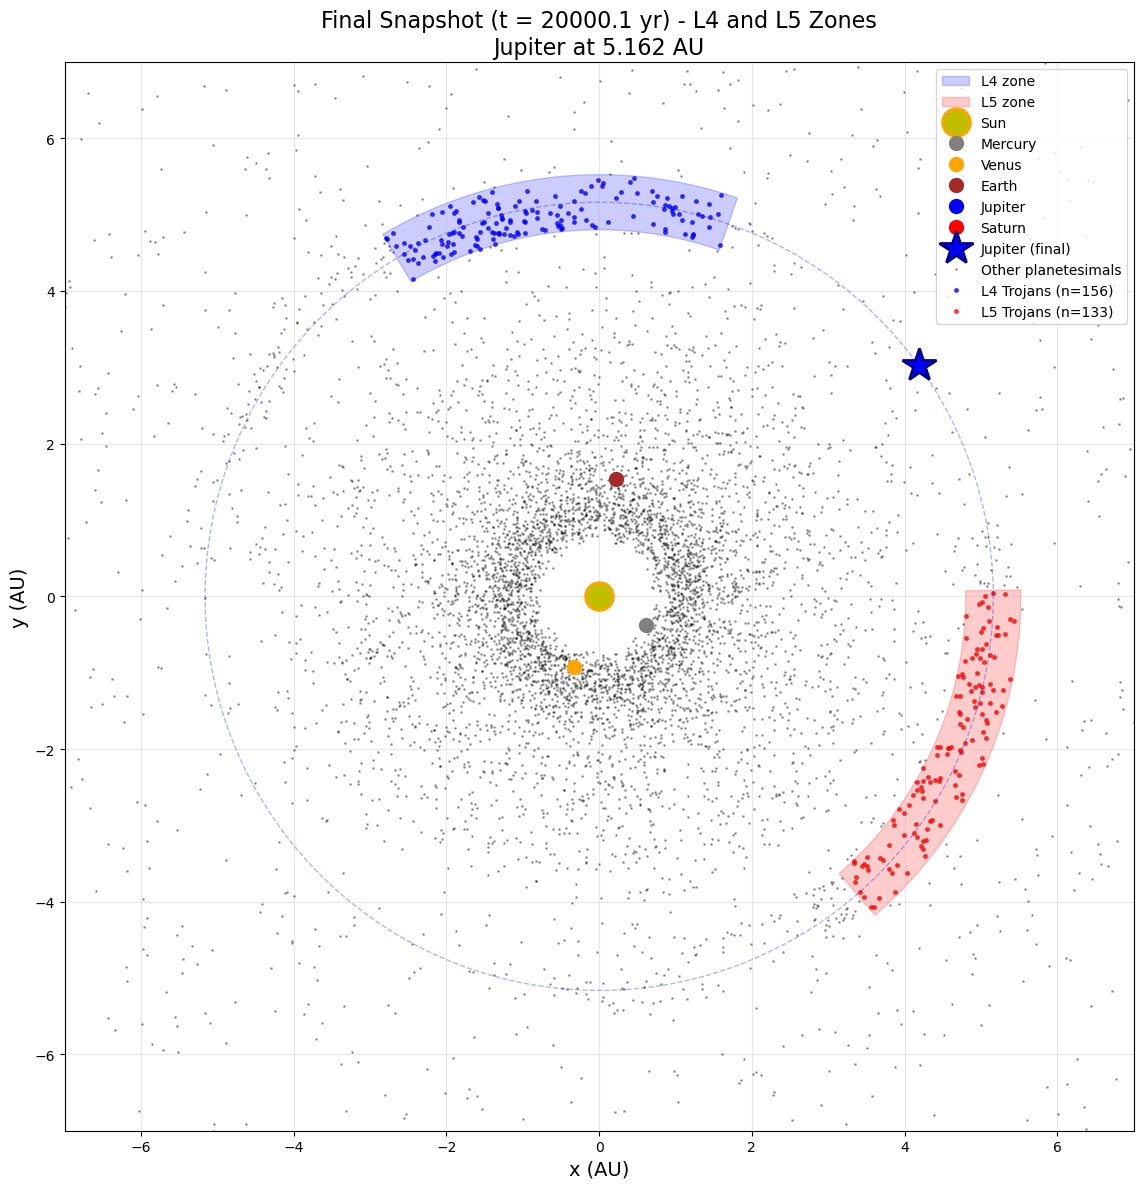


Final L4 count: 156
Final L5 count: 133
Other planetesimals: 9711
Total: 10000


In [ ]:
# Visualize final snapshot with L4 and L5 zones explicitly marked
fig, ax = plt.subplots(figsize=(12, 12))

# Get final snapshot
final_massive = snapshots_massive[-1]
final_planetesimals = snapshots_planetesimals[-1]
jupiter_final = final_massive[4]

# Jupiter's position and semi-major axis
jupiter_x = jupiter_final.x.value_in(units.AU)
jupiter_y = jupiter_final.y.value_in(units.AU)
jupiter_r = np.sqrt(jupiter_x**2 + jupiter_y**2)
jupiter_angle = np.arctan2(jupiter_y, jupiter_x)

# Draw L4 and L5 zones (±25° sectors at ±60° from Jupiter)
L4_angle = jupiter_angle + np.deg2rad(60)
L5_angle = jupiter_angle - np.deg2rad(60)
sector_width = np.deg2rad(25)

# L4 zone (leading Jupiter by 60°)
theta_L4 = np.linspace(L4_angle - sector_width, L4_angle + sector_width, 50)
r_inner_L4 = jupiter_r * 0.93  # 7% co-orbital criterion
r_outer_L4 = jupiter_r * 1.07
x_inner_L4 = r_inner_L4 * np.cos(theta_L4)
y_inner_L4 = r_inner_L4 * np.sin(theta_L4)
x_outer_L4 = r_outer_L4 * np.cos(theta_L4)
y_outer_L4 = r_outer_L4 * np.sin(theta_L4)
ax.fill(np.concatenate([x_inner_L4, x_outer_L4[::-1]]), 
        np.concatenate([y_inner_L4, y_outer_L4[::-1]]), 
        color='blue', alpha=0.2, label='L4 zone')

# L5 zone (trailing Jupiter by 60°)
theta_L5 = np.linspace(L5_angle - sector_width, L5_angle + sector_width, 50)
r_inner_L5 = jupiter_r * 0.93
r_outer_L5 = jupiter_r * 1.07
x_inner_L5 = r_inner_L5 * np.cos(theta_L5)
y_inner_L5 = r_inner_L5 * np.sin(theta_L5)
x_outer_L5 = r_outer_L5 * np.cos(theta_L5)
y_outer_L5 = r_outer_L5 * np.sin(theta_L5)
ax.fill(np.concatenate([x_inner_L5, x_outer_L5[::-1]]), 
        np.concatenate([y_inner_L5, y_outer_L5[::-1]]), 
        color='red', alpha=0.2, label='L5 zone')

# Plot Sun
ax.plot(0, 0, 'yo', markersize=20, markeredgecolor='orange', markeredgewidth=2, label='Sun', zorder=10)

# Plot massive bodies
colors_massive = ['gray', 'orange', 'brown', 'blue', 'red']
names_massive = ['Mercury', 'Venus', 'Earth', 'Jupiter', 'Saturn']
for i, body in enumerate(final_massive[1:6]):  # Skip Sun
    ax.plot(body.x.value_in(units.AU), body.y.value_in(units.AU), 
            'o', color=colors_massive[i], markersize=10, 
            label=names_massive[i], zorder=5)

# Plot Jupiter position markers
ax.plot(jupiter_x, jupiter_y, 'b*', markersize=25, markeredgecolor='darkblue', 
        markeredgewidth=2, label='Jupiter (final)', zorder=6)

# Classify and plot planetesimals
lambda_j = jupiter_angle
a_j = jupiter_r

L4_particles = []
L5_particles = []
other_particles = []

for p in final_planetesimals:
    x = p.x.value_in(units.AU)
    y = p.y.value_in(units.AU)
    r = np.sqrt(x**2 + y**2)
    lam = np.arctan2(y, x)
    dlam = np.arctan2(np.sin(lam - lambda_j), np.cos(lam - lambda_j))
    is_coorb = abs(r/a_j - 1) < 0.07
    
    if (dlam > np.deg2rad(60-25)) and (dlam < np.deg2rad(60+25)) and is_coorb:
        L4_particles.append((x, y))
    elif (dlam < np.deg2rad(-60+25)) and (dlam > np.deg2rad(-60-25)) and is_coorb:
        L5_particles.append((x, y))
    else:
        other_particles.append((x, y))

# Plot planetesimals by category
if other_particles:
    other_x, other_y = zip(*other_particles)
    ax.plot(other_x, other_y, 'k.', markersize=2, alpha=0.3, label='Other planetesimals')

if L4_particles:
    L4_x, L4_y = zip(*L4_particles)
    ax.plot(L4_x, L4_y, 'b.', markersize=5, alpha=0.7, label=f'L4 Trojans (n={len(L4_particles)})')

if L5_particles:
    L5_x, L5_y = zip(*L5_particles)
    ax.plot(L5_x, L5_y, 'r.', markersize=5, alpha=0.7, label=f'L5 Trojans (n={len(L5_particles)})')

# Draw Jupiter orbit
theta_orbit = np.linspace(0, 2*np.pi, 200)
ax.plot(jupiter_r * np.cos(theta_orbit), jupiter_r * np.sin(theta_orbit), 
        'b--', alpha=0.3, linewidth=1)

# Formatting
ax.set_xlabel('x (AU)', fontsize=14)
ax.set_ylabel('y (AU)', fontsize=14)
ax.set_title(f'Final Snapshot (t = {times[-1]:.1f} yr) - L4 and L5 Zones\nJupiter at {jupiter_r:.3f} AU', 
             fontsize=16)
ax.set_aspect('equal')
ax.grid(alpha=0.3)
ax.legend(loc='upper right', fontsize=10)

# Set reasonable plot limits
plot_limit = max(7, jupiter_r * 1.3)
ax.set_xlim(-plot_limit, plot_limit)
ax.set_ylim(-plot_limit, plot_limit)

plt.tight_layout()
plt.show()

print(f'\nFinal L4 count: {len(L4_particles)}')
print(f'Final L5 count: {len(L5_particles)}')
print(f'Other planetesimals: {len(other_particles)}')
print(f'Total: {len(final_planetesimals)}')
